

### Reproduction de résultats de la section 7.1 de l'article Proximal Algorithms in Statistics and Machine Learning (Polson 2015)

#### Khalil Bergaoui , Mohamed Amine Hachicha

In [1]:
# Importer bibliotheques utiles 

import numpy as np
import matplotlib.pyplot as plt
import scipy

In [2]:

def get_x(M):
    """
    Generer ue vecteur x de taille M de la loi normale
    """
    
    #Comme dans l'article, on méttera 10% des coefficients de x à zero
    nb_non_zero = M//10
    x = np.zeros(M)
    x_non_zero = np.random.normal(loc=0.0,scale=1.0,size=nb_non_zero)
    assert np.where(x_non_zero==0)[0].shape[0] ==0

    indices = np.random.choice(range(M),nb_non_zero,replace=False)
    x[indices] = x_non_zero
    assert np.where(x!=0)[0].shape[0] ==nb_non_zero
    return x 

In [3]:

def get_A(N,M):
    """
    Generer une matrice A de taille NxM de la loi normale
    """
    A = np.random.normal(loc=0.0,scale=1.0,size=(N,M))
    #On normalize les colonnes comme dans l'article
    from sklearn.preprocessing import normalize
    A = normalize(A,axis=1)
    return A
    

In [4]:
def get_p(A,x):
    #Calculer les probabilités p_i
    from scipy.special import expit #sigmoid
    p = expit(A@x)
    return p
def get_y(p,m_max):
    #
    m = np.random.randint(m_max,size=(p.shape))+1
    #Generaer y  de la loi binomiale
    y = np.random.binomial(m,p)
    return y,m

In [5]:
from scipy.special import expit


def prox_l1_norm(y, gamma, penalty):
    """
    Calculaer l'opérateur proximal pour la norme l1 avec 
    @y: vecteur pour lequel on évalue l'opérateur
    @gamma : réel designant le pas de descente de gradient
    @penalty: coefficient de penalisation Lasso (correspondant à la variable lambda)
    """
    y_int = y.copy()
    idx = np.abs(y_int) - gamma * penalty > 0
    y_int[idx] = (np.abs(y_int[idx]) - gamma * penalty) * np.sign(y_int[idx])
    y_int[~idx] = 0
    return y_int


def objective(A,x,y,m,lamda):
    """
    Fonction objective 
    """
    
    N = y.shape[0]
    return (np.sum(np.multiply(m,np.log(np.ones(y.shape[0])+np.exp(A@x))) - np.multiply(y,A@x))/np.sum(m)+ lamda*np.sum(np.abs(x)))

def unaccelerated(y,m,A,x,max_iter,x_0,theta='default',penalty=None):
    """
    Implementation de l'algorithme forward backward non accéléré
    """
    
    #Initialiser une liste pour les valeurs de la fonction objectif
    obj =[]
    
    #Determine la valeur singuliaire maximale de la matrice A
    eig_max = scipy.linalg.eigh(np.transpose(A)@A)[0].max()
    #Constante de lipschitz de la partie différentiable de la fonction objectif
    v = eig_max/4
    #pas de descente gradient
    gamma = 1.999 / v
    #Pénalisation Lasso
    if penalty == None:
        penalty = 0.1*eig_max
    if theta =='default':
        theta = 0.99 * (2 - gamma * v / 2) # =1
    
    
    K = np.transpose(A)@y 
    x_n = x_0
    for i in range(max_iter):
        loss= objective(A,x_n,y,m,penalty)
        obj.append(loss)
        x_n_1 = x_n
        
        target = np.multiply(m,expit(A@x_n))
        #iteration de descente gradient
        y_n = x_n - gamma * (np.transpose(A)@target -K)
        #Iteration utilisant l'opérateur proximal
        x_n = x_n + theta * (prox_l1_norm(y_n, gamma, penalty) - x_n)
        
            
    return x_n, obj

def accelerated(y,m,A,x,max_iter,x_0,theta='default',penalty=None):
    """
    
    Implementation de l'algorithme forward backward 
    avec aceeleration de Nesterov

    """
      #Initialiser une liste pour les valeurs de la fonction objectif
    obj =[]
    
    #Determine la valeur singuliaire maximale de la matrice A
    eig_max = scipy.linalg.eigh(np.transpose(A)@A)[0].max()
    #Constante de lipschitz de la partie différentiable de la fonction objectif
    v = eig_max/4
    #pas de descente gradient
    gamma = 1.999 / v
    #Pénalisation Lasso
    if penalty == None:
        penalty = 0.1*eig_max
    if theta =='default':
        #avec theta = 1 l'algorithme forward backward correspond à l'algorithme proximal 
        theta = 0.99 * (2 - gamma * v / 2) # =1
    
    
    K = np.transpose(A)@y 

    x_prev = x_0
    x_next = x_0
    for i in range(max_iter):
        loss= objective(A,x_next,y,m,penalty)
        obj.append(loss)
        
        #iteration de Nesterov
        acceleration = i/(i+2)
        z = x_prev + acceleration*(x_next-x_prev)
        target = np.multiply(m,expit(A@z))
        #iteration de descente gradient
        y_n = z - gamma * (np.transpose(A)@target -K)
        #Iteration utilisant l'opérateur proximal
        x_next = x_prev + theta * (prox_l1_norm(y_n, gamma, penalty) - x_prev)
        
    return x_next, obj

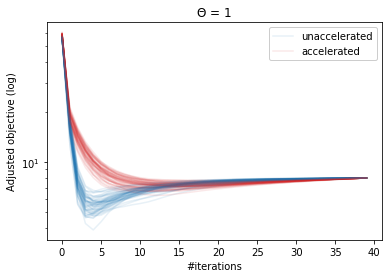

In [6]:
#Fixer la même random seed
seed = 42
np.random.seed(seed)

#Dimensions des vecteurs et matrice comme dans l'article
M=300
N=100
x = get_x(M)
A = get_A(N,M)
p = get_p(A,x)
#Nombre de réalisations de la variable y|p pour x et A donnés
trials = 50
m_max = 1


adj_param = 8 #ajouter à la fonction objective pour avoir des valeurs positives et tracer en echelle log


for n in range(trials):
    #Echantillonage aléatoire de la variable y
    y,m = get_y(p,m_max)
    
    #Initialization
    x_0 = np.ones(x.shape)
    
    #Resolution sans accéleration
    #on utilise 40 iterations au total
    x_n,obj_un = unaccelerated(y,m,A,x,40,x_0) 
    adj_obj_un = np.array(obj_un)-obj_un[-1]+adj_param #Ajuster la fonction objectif
    
    #Resolution avec accéleration de Nesterov
    #on utilise 40 iterations au total
    x_n,obj_acc = accelerated(y,m,A,x,40,x_0) 
    adj_obj_acc = np.array(obj_acc)-obj_acc[-1] +adj_param
    
    #Plot fonction objectif
    plt.plot(adj_obj_un,color ='tab:blue',alpha=0.1)
    plt.plot(adj_obj_acc,color ='tab:red',alpha=0.1)
    
    
    

plt.yscale('log')#Echelle log

plt.ylabel('Adjusted objective (log)')
plt.xlabel('#iterations')
plt.legend(['unaccelerated','accelerated'],framealpha=10)
tt=plt.title('$\Theta$ = 1')

*Remarque : La figure ci-dessus est obtenue en ajustant la fonction tracée de sorte à obtenir le même état final (car chaque courbe tracée correspond à une nouvelle résolution vu que le target y est échantilloné aléatoirement)*

In [7]:
eig_max = scipy.linalg.eigh(np.transpose(A)@A)[0].max()
v = eig_max/4
gamma = 1.999 / v
penalty = 0.1*eig_max

# Nous vérifions si on a bien penalty < gamma pour expliquer la non decroissance de la courbe bleue
print(gamma,penalty)

3.399524869968754 0.2352093397120373


Nous trouvon vien $\gamma = 3.39 > \lambda = 0.24$ ce qui explique le caractère non descendant de cet algorithme.En effet, comme le démontrent les auteurs dans la section APPENDIX A, la fonction objective $F$ du problème de minimization vérifie:
$$(\lambda -\gamma)\frac{1}{2}\left \| x_n - x* \right \| \leq F(x_n) - F(x*) $$


où $x*$ représente la solution finale. Donc pour imposer la décroissance il faut imposer$ \gamma  \leq \lambda$



Cette figure est obtenue pour une valeur de $\theta = 0.99$ du pas dans l'iteration faisant intervenir $prox_{\gamma f}$ pour $\theta = 1$ forward-backward est equivalent à l'algorithme proximal.
Nous remarquons que l'allure de cette figure dépend de la valeur de ce paramètre. En effet il est évident que pour des valeurs plus faibles, l'algorithme prend plus d'iterations pour converger. Cependant, l'apport de l'algorithme utilisant l'acceleration de Nesterov devient plus clair. Ci-dessous, nous retraçons la courbe pour $\theta = 0.7$ :  

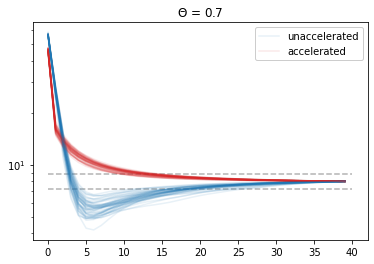

In [8]:
#Fixer la même random seed
seed = 42
np.random.seed(seed)

#Dimensions des vecteurs et matrice comme dans l'article
M=300
N=100
x = get_x(M)
A = get_A(N,M)
p = get_p(A,x)
#Nombre de réalisations de la variable y|p pour x et A donnés
trials = 50
m_max = 1
adj_param = 8 #ajouter à la fonction objective pour avoir des valeurs positives et tracer en echelle log

prox_step = 0.7
for n in range(trials):
    #Echantillonage aléatoire de la variable y
    y,m = get_y(p,m_max)
    
    #Initialization
    x_0 = np.ones(x.shape)
    
    #Resolution sans accéleration
    #on utilise 40 iterations au total
    x_n,obj_un = unaccelerated(y,m,A,x,40,x_0,prox_step) 
    adj_obj_un = np.array(obj_un)-obj_un[-1]+adj_param #Ajuster la fonction objectif
    
    #Resolution avec accéleration de Nesterov
    #on utilise 40 iterations au total
    x_n,obj_acc = accelerated(y,m,A,x,40,x_0,prox_step) 
    adj_obj_acc = np.array(obj_acc)-obj_acc[-1] +adj_param
    
    #Plot fonction objectif
    plt.plot(adj_obj_un,color ='tab:blue',alpha=0.1)
    plt.plot(adj_obj_acc,color ='tab:red',alpha=0.1)
    
    
tol = 0.1*adj_param    
plt.hlines([adj_param+tol,adj_param-tol],xmin=0,xmax=40, alpha=0.3,ls='--')
plt.yscale('log')
plt.legend(['unaccelerated','accelerated'],framealpha=10)
tt=plt.title('$\Theta$ = {}'.format(prox_step))

Dans ce cas, la fonction objective pour l'algorithme accéleré(en rouge) passe dès les premières iterations sous celle l'algorithme non acceléré (en bleu) et se trouve dans un voisinage de la valeur finale plus rapidement. 
Par rapport à la figure précedente, nous pouvons conclure que pour notre cas d'usage, combiner 'acceleration de Nesterov et la méthode proximale est efficace plus $\theta$ est petit (théoriquement ken fama upper bound tji remarque fi blasetha) 

Ci-dessous pour $\theta = 0.5$

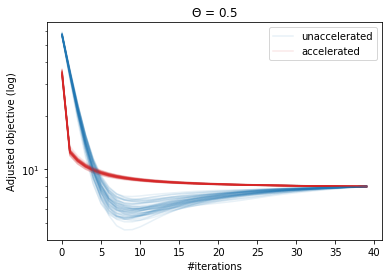

In [9]:
#Fixer la même random seed
seed = 42
np.random.seed(seed)

#Dimensions des vecteurs et matrice comme dans l'article
M=300
N=100
x = get_x(M)
A = get_A(N,M)
p = get_p(A,x)
#Nombre de réalisations de la variable y|p pour x et A donnés
trials = 50
m_max = 1
adj_param = 8 #ajouter à la fonction objective pour avoir des valeurs positives et tracer en echelle log

prox_step = 0.5
for n in range(trials):
    #Echantillonage aléatoire de la variable y
    y,m = get_y(p,m_max)
    
    #Initialization
    x_0 = np.ones(x.shape)
    
    #Resolution sans accéleration
    #on utilise 40 iterations au total
    x_n,obj_un = unaccelerated(y,m,A,x,40,x_0,prox_step) 
    adj_obj_un = np.array(obj_un)-obj_un[-1]+adj_param #Ajuster la fonction objectif
    
    #Resolution avec accéleration de Nesterov
    #on utilise 40 iterations au total
    x_n,obj_acc = accelerated(y,m,A,x,40,x_0,prox_step) 
    adj_obj_acc = np.array(obj_acc)-obj_acc[-1] +adj_param
    
    #Plot fonction objectif
    plt.plot(adj_obj_un,color ='tab:blue',alpha=0.1)
    plt.plot(adj_obj_acc,color ='tab:red',alpha=0.1)
    
    
#plt.hlines([adj_param+tol,adj_param-tol],xmin=0,xmax=40, alpha=0.3,ls='--')
plt.yscale('log')
plt.ylabel('Adjusted objective (log)')
plt.xlabel('#iterations')
plt.legend(['unaccelerated','accelerated'])
tt=plt.title('$\Theta$ = {}'.format(prox_step))

Pour $\theta =0.5$,  on converge $\approx 2.5$ fois plus rapidement avec l'accéleration de Nesterov